In [ ]:
!wget -O "labelled_images.zip" https://files.osf.io/v1/resources/dv2ag/providers/googledrive/labelled_images/?zip=


--2023-10-20 01:39:28--  https://files.osf.io/v1/resources/dv2ag/providers/googledrive/labelled_images/?zip=
Resolving files.osf.io (files.osf.io)... 35.186.214.196
Connecting to files.osf.io (files.osf.io)|35.186.214.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘labelled_images.zip’

labelled_images.zip     [           <=>      ] 520.93M  1.03MB/s    in 3m 7s   

2023-10-20 01:42:44 (2.79 MB/s) - ‘labelled_images.zip’ saved [546231453]



In [ ]:
!unzip "/content/labelled_images.zip" -d /content/drive/MyDrive/datasetfinal

Archive:  /content/labelled_images.zip
 extracting: /content/drive/MyDrive/datasetfinal/ulcer.tar.gz  
 extracting: /content/drive/MyDrive/datasetfinal/reduced_mucosal_view.tar.gz  
 extracting: /content/drive/MyDrive/datasetfinal/pylorus.tar.gz  
 extracting: /content/drive/MyDrive/datasetfinal/normal_clean_mucosa.tar.gz  
 extracting: /content/drive/MyDrive/datasetfinal/polyp.tar.gz  
 extracting: /content/drive/MyDrive/datasetfinal/lymphangiectasia.tar.gz  
 extracting: /content/drive/MyDrive/datasetfinal/ileocecal_valve.tar.gz  
 extracting: /content/drive/MyDrive/datasetfinal/foreign_body.tar.gz  
 extracting: /content/drive/MyDrive/datasetfinal/erythema.tar.gz  
 extracting: /content/drive/MyDrive/datasetfinal/erosion.tar.gz  
 extracting: /content/drive/MyDrive/datasetfinal/blood_fresh.tar.gz  
 extracting: /content/drive/MyDrive/datasetfinal/angiectasia.tar.gz  
 extracting: /content/drive/MyDrive/datasetfinal/blood_hematin.tar.gz  
 extracting: /content/drive/MyDrive/datasetfi

In [ ]:
%cd /content/drive/MyDrive/datasetfinal

/content/drive/MyDrive/datasetfinal


In [ ]:
ls *.gz |xargs -n1 tar -xzf


In [ ]:
!rm *.gz

In [ ]:
%cd "/content"


/content


In [ ]:
import cv2
import glob
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd


In [ ]:
# Define the data directory where your images are stored
datadir = '/content/drive/MyDrive/datasetfinal'


In [ ]:
# Get a list of all subdirectories (each subdirectory corresponds to a class)
category_dirs = [x for x in os.scandir(datadir) if x.is_dir()]
categories = [x.name for x in category_dirs]

In [ ]:

# Print the number of categories and the list of category names
print("Number of categories:", len(categories))
print(categories)

Number of categories: 14
['Ampulla of vater', 'Angiectasia', 'Blood - fresh', 'Blood - hematin', 'Erosion', 'Erythema', 'Foreign body', 'Ileocecal valve', 'Lymphangiectasia', 'Normal clean mucosa', 'Polyp', 'Pylorus', 'Reduced mucosal view', 'Ulcer']


In [ ]:
test_img = cv2.imread('/content/datasetfinal/Ampulla of vater/eb0203196e284797_1157.jpg')

In [ ]:
test_img.shape

In [ ]:
img_size = (224,244)

In [ ]:
# Create the training and validation datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    datadir,
    validation_split=0.2,
    subset="training",
    label_mode="categorical",
    seed=123,
    image_size=img_size,
    batch_size=32,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    datadir,
    validation_split=0.2,
    subset="validation",
    label_mode="categorical",
    seed=123,
    image_size=img_size,
    batch_size=32,
)

Found 47238 files belonging to 14 classes.
Using 37791 files for training.
Found 47238 files belonging to 14 classes.
Using 9447 files for validation.


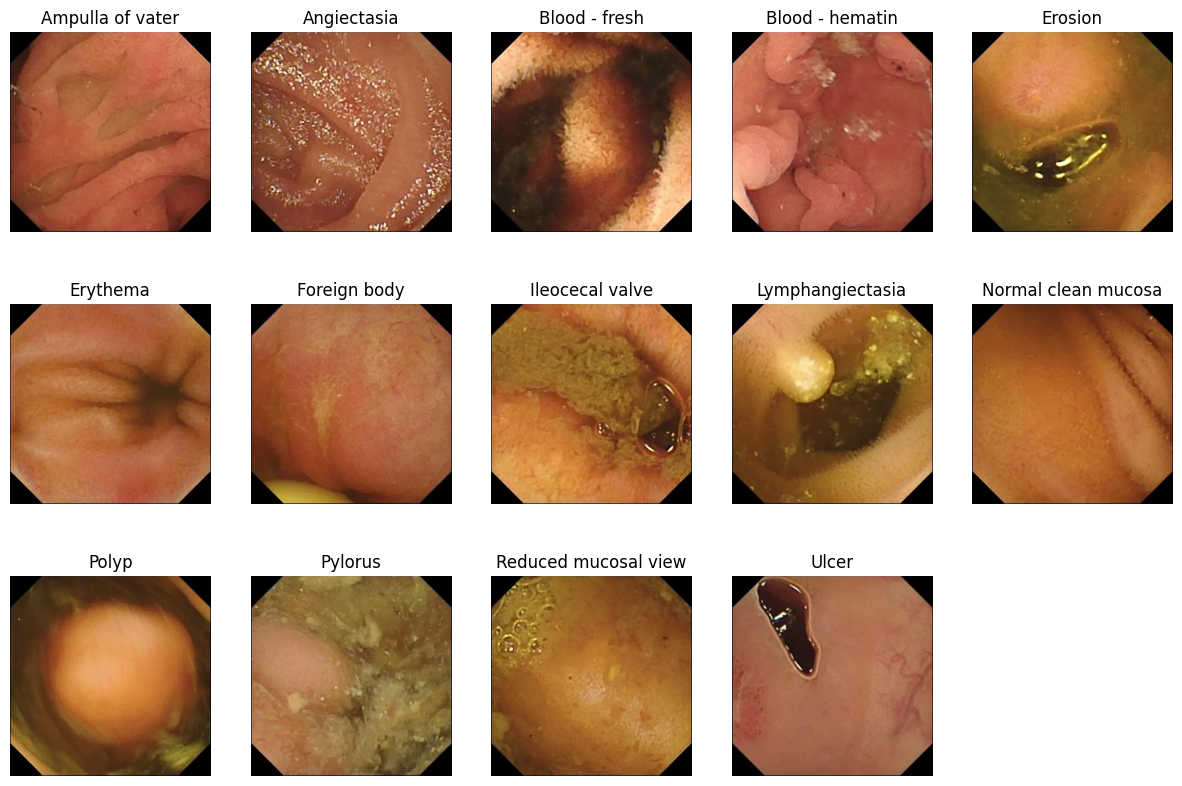

In [ ]:
# Visualize sample images from different categories
plt.figure(figsize=(15, 10))
plot_num = 1
for cat_dir in category_dirs:
    img_path = random.choice(os.listdir(cat_dir.path))
    img = cv2.imread(os.path.join(cat_dir, img_path))
    plt.subplot(3, 5, plot_num)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(cat_dir.name)
    plt.axis("off")
    plot_num += 1
plt.show()

In [ ]:
category_counts = {}
for cat_dir in category_dirs:
    category_name = cat_dir.name
    count = len([f for f in os.listdir(cat_dir) if f.endswith('.jpg')])
    category_counts[category_name] = count

category_counts = pd.DataFrame.from_dict(category_counts, orient="index", columns=["count"])
category_counts.sort_values("count", ascending=False, inplace=True)
print(category_counts)


                      count
Normal clean mucosa   34338
Ileocecal valve        4189
Reduced mucosal view   2906
Pylorus                1529
Angiectasia             866
Ulcer                   854
Foreign body            776
Lymphangiectasia        592
Erosion                 506
Blood - fresh           446
Erythema                159
Polyp                    55
Blood - hematin          12
Ampulla of vater         10


In [ ]:

# Load the pre-trained InceptionV3 model with pre-trained weights (excluding the top classification layers)
base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=(img_size[0], img_size[1], 3))


87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
# Add custom classification layers on top of the InceptionV3 base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(len(categories), activation="softmax")(x)


In [ ]:
# Create your custom model by specifying the input and output layers
model = Model(inputs=base_model.input, outputs=predictions)


In [ ]:

# Freeze the layers of the InceptionV3 base model
for layer in base_model.layers:
    layer.trainable = False


In [ ]:
# Define the data augmentation settings
datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)


In [ ]:

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])


In [ ]:

# Create a checkpoint to save the best model
model_checkpoint = ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)


In [ ]:

# Define learning rate reduction callback
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=0.00001, verbose=1)


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import class_weight

# Define your data directories
img_size = (224,244)  # Specify the image size
batch_size = 32  # Specify your batch size
num_classes = 14  # Specify the number of classes


# Load the pre-trained InceptionV3 model with pre-trained weights (excluding the top classification layers)
base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=(img_size[0], img_size[1], 3))


# Freeze the layers of the InceptionV3 base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers on top of the InceptionV3 base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(len(categories), activation="softmax")(x)

# Create your custom model by specifying the input and output layers
model = Model(inputs=base_model.input, outputs=predictions)


# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])


# Define early stopping and learning rate scheduler
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)


# Create a checkpoint to save the best model
model_checkpoint = ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)


# Define the number of training epochs
num_epochs = 30

# Train the model
history = model.fit(
    train_ds,
    steps_per_epoch=len(train_ds),
    epochs=num_epochs,
    validation_data=val_ds,
    validation_steps=len(val_ds),
    callbacks=[model_checkpoint, reduce_lr],
)

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(val_ds)
print("Test accuracy:", test_acc)



Epoch 1/30
1181/1181 [==============================] - ETA: 0s - loss: 1.3647 - accuracy: 0.7324
Epoch 1: val_accuracy improved from -inf to 0.70499, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1181/1181 [==============================] - 143s 108ms/step - loss: 1.3647 - accuracy: 0.7324 - val_loss: 1.1007 - val_accuracy: 0.7050 - lr: 1.0000e-04
Epoch 2/30
1181/1181 [==============================] - ETA: 0s - loss: 0.8894 - accuracy: 0.7868
Epoch 2: val_accuracy improved from 0.70499 to 0.82704, saving model to best_model.h5
1181/1181 [==============================] - 126s 106ms/step - loss: 0.8894 - accuracy: 0.7868 - val_loss: 0.6292 - val_accuracy: 0.8270 - lr: 1.0000e-04
Epoch 3/30
1181/1181 [==============================] - ETA: 0s - loss: 0.7849 - accuracy: 0.8051
Epoch 3: val_accuracy improved from 0.82704 to 0.82841, saving model to best_model.h5
1181/1181 [==============================] - 123s 104ms/step - loss: 0.7849 - accuracy: 0.8051 - val_loss: 0.9708 - val_accuracy: 0.8284 - lr: 1.0000e-04
Epoch 4/30
1181/1181 [==============================] - ETA: 0s - loss: 0.6652 - accuracy: 0.8264
Epoch 4: val_accuracy improved from 0.82841 to 0.83381, saving model to 

In [ ]:
model.save('/content/drive/MyDrive/inceptionv3.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:

import pickle
# Save the training history to a file using pickle
with open('/content/drive/MyDrive/newtraining_history.pkl', 'wb') as pickle_file:
    pickle.dump(history.history, pickle_file)

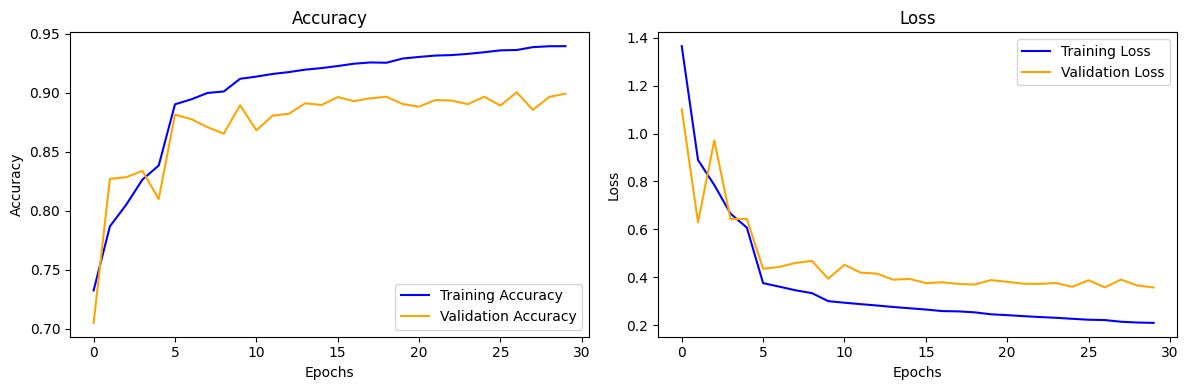

In [ ]:
import pickle
import matplotlib.pyplot as plt

# Load the training history from the pickle file
with open('/content/drive/MyDrive/newtraining_history.pkl', 'rb') as pickle_file:
    history = pickle.load(pickle_file)

# Extract training and validation accuracy and loss
train_acc = history['accuracy']
val_acc = history['val_accuracy']
train_loss = history['loss']
val_loss = history['val_loss']

# Create subplots for accuracy and loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot training and validation accuracy
ax1.set_title('Accuracy')
ax1.plot(train_acc, label='Training Accuracy', color='blue')
ax1.plot(val_acc, label='Validation Accuracy', color='orange')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='lower right')

# Plot training and validation loss
ax2.set_title('Loss')
ax2.plot(train_loss, label='Training Loss', color='blue')
ax2.plot(val_loss, label='Validation Loss', color='orange')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import os
import random

# Load your saved model
model = tf.keras.models.load_model('/content/drive/MyDrive/inceptionv3.h5')

In [ ]:
test_accu = model.evaluate(val_ds)
print('The testing accuracy is :',test_accu[1]*100, '%')

296/296 [==============================] - 28s 84ms/step - loss: 0.3572 - accuracy: 0.8992
The testing accuracy is : 89.92272615432739 %


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import os
import random
from sklearn.metrics import classification_report, confusion_matrix

# Load your saved model
loaded_model =tf.keras.models.load_model('/content/drive/MyDrive/inceptionv3.h5')

# Initialize empty lists to store ground truth and predictions
ground_truth = []
predictions = []

# Loop through the validation dataset to get true labels and model predictions
for images, labels in val_ds:
    true_labels = np.argmax(labels, axis=1)  # Convert one-hot encoded labels to class indices
    predicted_labels = loaded_model.predict(images)
    predicted_labels = np.argmax(predicted_labels, axis=1)  # Convert model predictions to class indices

    ground_truth.extend(true_labels)
    predictions.extend(predicted_labels)

# Calculate and print classification report
class_names = ["Ampulla of vater", "Blood - hematin", "Polyp", "Erythema", "Blood - fresh", "Erosion",
               "Lymphangiectasia", "Foreign body", "Ulcer", "Angiectasia", "Pylorus", "Reduced mucosal view",
               "Ileocecal valve", "Normal clean mucosa"]

print(classification_report(ground_truth, predictions, target_names=class_names))

# Calculate and print confusion matrix
conf_matrix = confusion_matrix(ground_truth, predictions)
print("Confusion Matrix:")
print(conf_matrix)


1/1 [==============================] - 1s 1s/step
                      precision    recall  f1-score   support

    Ampulla of vater       0.00      0.00      0.00         2
     Blood - hematin       0.91      0.69      0.78       172
               Polyp       0.89      0.78      0.83        79
            Erythema       1.00      1.00      1.00         4
       Blood - fresh       0.83      0.25      0.39       119
             Erosion       1.00      0.29      0.44        35
    Lymphangiectasia       0.91      0.63      0.74       167
        Foreign body       0.78      0.83      0.81       829
               Ulcer       0.69      0.70      0.70       126
         Angiectasia       0.93      0.96      0.94      6875
             Pylorus       1.00      1.00      1.00        11
Reduced mucosal view       0.65      0.67      0.66       309
     Ileocecal valve       0.93      0.80      0.86       552
 Normal clean mucosa       0.89      0.71      0.79       167

            accura

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input
import numpy as np
import cv2

# Load an image for prediction
image_path = '/content/drive/MyDrive/datasetfinal/Blood - fresh/04a78ef00c5245e0_11213.jpg'
img = image.load_img(image_path, target_size=(224, 244))  # Resize the image to (224, 244)

# Preprocess the image
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = preprocess_input(img)  # Preprocess the image according to the InceptionV3 model

# Use the model for prediction
predictions = inceptionv3.predict(img)


1/1 [==============================] - 0s 56ms/step


In [ ]:
# Define a dictionary to map class indices to class labels
class_mapping = {
    0: "Normal clean mucosa",
    1: "Ileocecal valve",
    2: "Reduced mucosal view",
    3: "Pylorus",
    4: "Angiectasia",
    5: "Ulcer",
    6: "Foreign body",
    7: "Lymphangiectasia",
    8: "Erosion",
    9: "Blood - fresh",
    10: "Erythema",
    11: "Polyp",
    12: "Blood - hematin",
    13: "Ampulla of vater",
}

# Use the model for prediction
predictions = best_model.predict(img)

# Find the index of the class with the highest prediction score
predicted_class_index = np.argmax(predictions, axis=1)

# Get the corresponding class label
predicted_class_label = class_mapping[predicted_class_index[0]]

print(f"The predicted class is: {predicted_class_label}")


1/1 [==============================] - 0s 50ms/step
The predicted class is: Blood - fresh


In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
inceptionv3 = load_model('/content/drive/MyDrive/inceptionv3.h5')
